In [16]:
# ============================================
# 1. IMPORTS
# ============================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt


In [17]:
# ============================================
# 2. LOAD & PREPROCESS DATA
# ============================================
# path of original dataset
data_path = "/content/ecommerce_sales_34500.csv"

df = pd.read_csv(data_path)
print("Original shape:", df.shape)

# ---- drop date columns ----
date_cols = [col for col in df.columns if "date" in col.lower()]
df = df.drop(columns=date_cols)
print("After dropping date cols:", df.shape)

# ---- encode target column 'returned' ----
le_returned = LabelEncoder()
df["returned"] = le_returned.fit_transform(df["returned"].astype(str))

# ---- id columns (we won't use in model) ----
skip_id_cols = ["order_id", "customer_id", "product_id"]

# ---- label encode categorical columns with alphabets ----
label_encoders = {}
alpha_cols = []

for col in df.columns:
    if col in skip_id_cols or col == "returned":
        continue
    if df[col].dtype == "object":
        has_alpha = df[col].astype(str).str.contains(r"[A-Za-z]", regex=True, na=False).any()
        if has_alpha:
            alpha_cols.append(col)

for col in alpha_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# ---- basic numeric imputation (for current df) ----
df = df.fillna(df.median(numeric_only=True))

print("Columns after preprocessing:", df.columns.tolist())
df.head()


Original shape: (34500, 17)
After dropping date cols: (34500, 16)
Columns after preprocessing: ['order_id', 'customer_id', 'product_id', 'category', 'price', 'discount', 'quantity', 'payment_method', 'delivery_time_days', 'region', 'returned', 'total_amount', 'shipping_cost', 'profit_margin', 'customer_age', 'customer_gender']


,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
0,O100000,C17270,P234890,4,164.08,0.15,1,1,4,4,0,139.47,7.88,31.17,60,0
1,O100001,C17603,P228204,3,24.73,0.00,1,1,6,3,0,24.73,4.60,-2.62,37,1
2,O100002,C10860,P213892,1,175.58,0.05,1,1,4,2,0,166.80,6.58,13.44,34,1
3,O100003,C15390,P208689,1,63.67,0.00,1,4,6,3,0,63.67,5.50,2.14,21,0
4,O100004,C15226,P228063,4,16.33,0.15,1,0,6,1,0,13.88,2.74,1.15,39,1


In [18]:
# ============================================
# 3. BUILD X, y AND MAKE EVERYTHING NUMERIC
# ============================================
label_col = "returned"
y = df[label_col]
X = df.drop(columns=[label_col])

# drop ID columns from features
X_model = X.drop(columns=skip_id_cols, errors="ignore")

# ---- NEW: force all remaining columns to numeric ----
for col in X_model.columns:
    if not np.issubdtype(X_model[col].dtype, np.number):
        X_model[col] = pd.to_numeric(X_model[col].astype(str), errors="coerce")

# fill NaNs created by coercion
X_model = X_model.fillna(X_model.median(numeric_only=True))

print("X_model dtypes:")
print(X_model.dtypes)


X_model dtypes:
category                int64
price                 float64
discount              float64
quantity                int64
payment_method          int64
delivery_time_days      int64
region                  int64
total_amount          float64
shipping_cost         float64
profit_margin         float64
customer_age            int64
customer_gender         int64
dtype: object


In [19]:
# ============================================
# 4. TRAIN / TEST SPLIT + SMOTE
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE - X_train_res:", X_train_res.shape)
print("Class balance after SMOTE:", np.bincount(y_train_res))

# save train/test csvs (optional)
train_smote = pd.DataFrame(X_train_res, columns=X_model.columns)
train_smote[label_col] = y_train_res.values
train_smote.to_csv("ecommerce_train_smote.csv", index=False)

test_df = pd.DataFrame(X_test, columns=X_model.columns)
test_df[label_col] = y_test.values
test_df.to_csv("ecommerce_test.csv", index=False)


X_train shape: (27600, 12)
y_train shape: (27600,)
After SMOTE - X_train_res: (52156, 12)
Class balance after SMOTE: [26078 26078]


In [20]:
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)

# -----------------------------------------
# Train SVM (RBF kernel, with probabilities)
# -----------------------------------------
svm_model = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",   # handles imbalance (even though we used SMOTE)
    probability=True,          # VERY important for predict_proba()
    random_state=42
)

svm_model.fit(X_train_res, y_train_res)
print("✅ SVM MODEL TRAINED!")


✅ SVM MODEL TRAINED!


Confusion Matrix:
 [[3517 3002]
 [ 177  204]]

Accuracy: 0.5392753623188405
Precision: 0.06363069245165315
Recall: 0.5354330708661418
F1-score: 0.11374407582938388
ROC-AUC: 0.5505465751433625


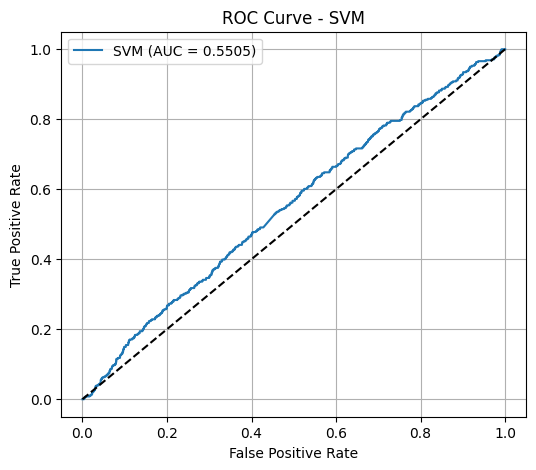

In [21]:
# -----------------------------------------
# Evaluation on original test set
# -----------------------------------------
y_pred_svm = svm_model.predict(X_test)
y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
prec = precision_score(y_test, y_pred_svm)
rec = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
roc_auc = roc_auc_score(y_test, y_prob_svm)

print("Confusion Matrix:\n", cm)
print("\nAccuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

# ROC curve (optional)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.grid(True)
plt.show()
